In [1]:
import os
import obspy.clients.fdsn
import numpy as np
import pandas as pd
import obspy
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime
import scipy
import warnings
warnings.filterwarnings("ignore")

# Area based event search

In [10]:
client = "IRIS"

# dates to request data for

starttime = obspy.UTCDateTime("2011-11-14T00:00:00")
endtime = obspy.UTCDateTime("2011-12-11T00:00:00")

# define map extent
minlatitude = 34.16
maxlatitude = 36.03
minlongitude = -88.45
maxlongitude = -91.52

# min and max requested magnitudes
minmagnitude = 3
maxmagnitude = 9

client = obspy.clients.fdsn.Client(client)

events = client.get_events(minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude,
                           starttime=starttime,
                           endtime=endtime,
                           minmagnitude=minmagnitude,maxmagnitude=maxmagnitude)

print("found %s event(s):" % len(events))
print(events)

found 221 event(s):
221 Event(s) in Catalog:
2011-12-10T17:38:45.180000Z | +34.708, +141.853 | 3.5  mb
2011-12-10T14:02:12.100000Z | +35.140, +142.330 | 3.0  None
...
2011-11-14T05:31:42.000000Z | +35.521,  -96.782 | 4.1  ML
2011-11-14T01:51:54.100000Z | +34.740, +142.680 | 3.1  None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [11]:
feature_list = ['Origin Time (UTC)', 'Lat', 'Long', 'depth [m]', 'event_type', 'mag', 'magnitude_type', 'creation_info', 'info']
df = pd.DataFrame(0, index=np.arange(len(events)), columns=feature_list)

for ii in range (0, len(events)):
    df['Origin Time (UTC)'].loc[ii] = events[ii].origins[0].time
    df['Lat'].loc[ii] = events[ii].origins[0].latitude
    df['Long'].loc[ii] = events[ii].origins[0].longitude
    df['depth [m]'].loc[ii] = events[ii].origins[0].depth    
    df['event_type'].loc[ii] = events[ii].event_type   
    df['mag'].loc[ii] = events[ii].magnitudes[0].mag     
    df['magnitude_type'].loc[ii] = events[ii].magnitudes[0].magnitude_type    
    df['creation_info'].loc[ii] = events[ii].origins[0].creation_info 
    df['info'].loc[ii] = events[ii].event_descriptions[0].text

In [12]:
df

,Origin Time (UTC),Lat,Long,depth [m],event_type,mag,magnitude_type,creation_info,info
0,2011-12-10T17:38:45.180000Z,34.7081,141.8529,13700.0,earthquake,3.5,mb,"[agency_id, agency_uri, author, author_uri, cr...","OFF EAST COAST OF HONSHU, JAPAN"
1,2011-12-10T14:02:12.100000Z,35.1400,142.3300,50000.0,earthquake,3.0,None,"[agency_id, agency_uri, author, author_uri, cr...","OFF EAST COAST OF HONSHU, JAPAN"
2,2011-12-10T12:08:41.270000Z,34.6472,23.9144,26600.0,earthquake,4.0,mb,"[agency_id, agency_uri, author, author_uri, cr...","CRETE, GREECE"
3,2011-12-10T04:19:28.170000Z,35.5648,140.1297,70600.0,earthquake,4.2,mb,"[agency_id, agency_uri, author, author_uri, cr...","NEAR EAST COAST OF HONSHU, JAPAN"
4,2011-12-10T04:10:38.600000Z,35.2000,142.5200,60000.0,earthquake,3.0,None,"[agency_id, agency_uri, author, author_uri, cr...","OFF EAST COAST OF HONSHU, JAPAN"
...,...,...,...,...,...,...,...,...,...
216,2011-11-14T16:57:14.000000Z,34.6600,142.7400,58000.0,earthquake,3.1,None,"[agency_id, agency_uri, author, author_uri, cr...","OFF EAST COAST OF HONSHU, JAPAN"
217,2011-11-14T14:07:05.200000Z,35.7900,143.1900,91000.0,earthquake,3.1,None,"[agency_id, agency_uri, author, author_uri, cr...","OFF EAST COAST OF HONSHU, JAPAN"
218,2011-11-14T06:53:00.100000Z,35.0800,132.4900,11000.0,earthquake,3.3,None,"[agency_id, agency_uri, author, author_uri, cr...","WESTERN HONSHU, JAPAN"
219,2011-11-14T05:31:42.000000Z,35.5210,-96.7820,3100.0,earthquake,4.1,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA


In [13]:
df['event_type'].value_counts()

earthquake    221
Name: event_type, dtype: int64

In [15]:
earthquake_data = np.zeros((52,3,1600))
earthquake_data.shape

(52, 3, 1600)

# Earthquake Signals

In [17]:
client = obspy.clients.fdsn.Client("IRIS")
for i in range(52):
    st = obspy.UTCDateTime(df['Origin Time (UTC)'][i].datetime.strftime("%Y-%m-%d %H:%M:%S"))
    wavedata = client.get_waveforms(network="TA",
                            station = "V44A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
    
    for j in range(3):
        if len(wavedata[j].data)<1600:
            p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
            diff = 1600-len(wavedata[j].data)
            for ii in range(diff):
                p.append(0)
            earthquake_data[i,j,:] = np.array(p)
            
        elif len(wavedata[j].data)>1600:
            earthquake_data[i,j,:] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
        else:
            earthquake_data[i,j,:] = wavedata[j].data/(abs(wavedata[j].data).max())
        
        
    if(i+1)%10==0: print("{} earthquake samples collected...".format(i+1))
        
print("Total no. of earthquake samples: ",earthquake_data.shape[0])

10 earthquake samples collected...
20 earthquake samples collected...
30 earthquake samples collected...
40 earthquake samples collected...
50 earthquake samples collected...
Total no. of earthquake samples:  52


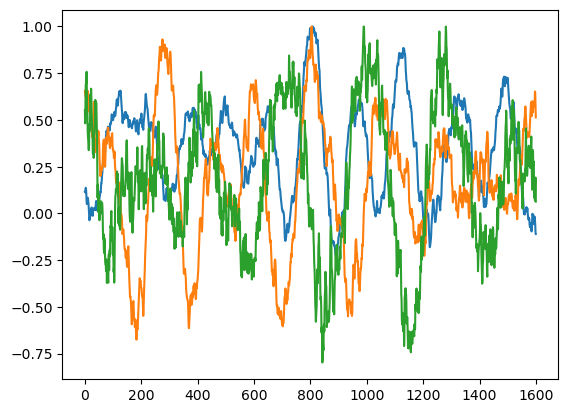

In [19]:
plt.plot(earthquake_data[1,:].T)

In [20]:
np.save("IRIS_earthquake_waveforms_52.npy",earthquake_data)

# Non-Earthquake Signal

In [24]:
client = obspy.clients.fdsn.Client("IRIS")
starttime = "2011-11-14T00:00:00"
#endtime = "2012-02-09T23:59:59"
st = obspy.UTCDateTime(starttime)
et = obspy.UTCDateTime(endtime)

noise = []
s=0
while(s<146):    
    for j in range(len(df)):
        t = df['Origin Time (UTC)'][j].datetime.strftime("%Y-%m-%d %H:%M:%S")
        t1 = obspy.UTCDateTime(t)
        t2 = t1+40
        if st+40<t1:
            overlap=False
        elif st>t2:
            overlap=False
        else:
            overlap=True
            break
        
    if overlap==False:
        wavedata = client.get_waveforms(network="TA",
                            station = "V44A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
        
        noise2 = np.zeros((3,1600))
        for j in range(3):
            if len(wavedata[j].data)<1600:
                p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
                diff = 1600-len(wavedata[j].data)
                for ii in range(diff):
                    p.append(0)
                noise2[j] = np.array(p)
                
            elif len(wavedata[j].data)>1600:
                noise2[j] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
            else:
                noise2[j] = wavedata[j].data/(abs(wavedata[j].data).max())
                
        noise.append(noise2)
        s+=1
    
    if s%30==0: print("{} non-earthquake samples collected...".format(s))
    st = st+40

noise_data = np.array(noise)
print("Total no. of non-earthquake samples: ",noise_data.shape[0])

30 non-earthquake samples collected...
60 non-earthquake samples collected...
90 non-earthquake samples collected...
120 non-earthquake samples collected...
Total no. of non-earthquake samples:  146


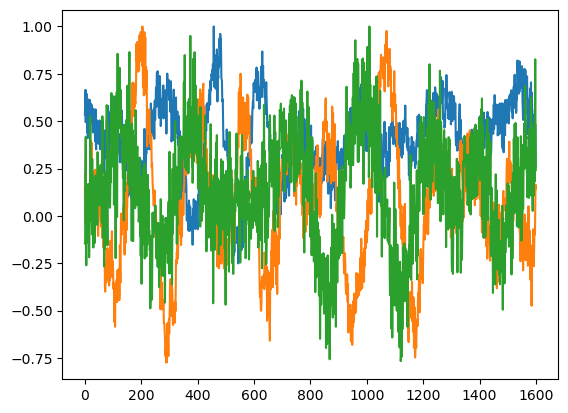

In [25]:
plt.plot(noise_data[100].T)

In [35]:
noise_data.shape

(146, 3, 1600)

In [26]:
np.save("IRIS_non_earthquake_waveforms_146_samples.npy", noise_data)

In [40]:
y_earthquake_data = np.ones((52,1))
y_noise_data = np.zeros((len(noise_data),1))
W = np.concatenate([earthquake_data,noise_data], axis=0)
Y = np.concatenate([y_earthquake_data, y_noise_data], axis=0)
W.shape,Y.shape

((198, 3, 1600), (198, 1))

In [41]:
earthquake_data.shape, noise_data.shape

((52, 3, 1600), (146, 3, 1600))

In [42]:
W.shape,Y.shape

((198, 3, 1600), (198, 1))

In [43]:
seed = 42
np.random.seed(seed)
np.random.shuffle(W)
np.random.seed(seed)
np.random.shuffle(Y)

In [44]:
Y

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],

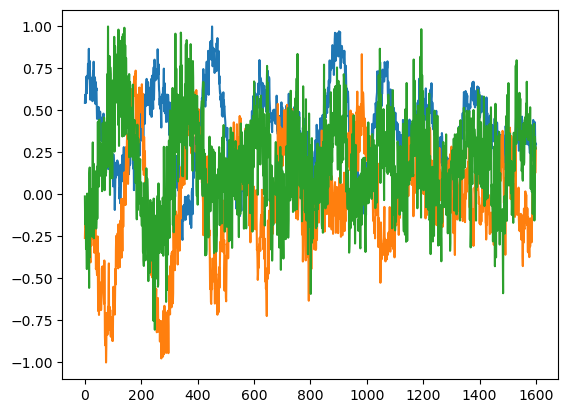

In [45]:
plt.plot(W[0].T)

In [46]:
np.max(earthquake_data), np.min(earthquake_data)

(1.0, -1.0)

In [47]:
np.max(noise_data), np.min(noise_data)

(1.0, -1.0)

In [48]:
W.shape

(198, 3, 1600)

In [49]:
np.save("IRIS_dataset_waveforms_test.npy", W)
np.save("IRIS_dataset_labels_test.npy",Y)

In [50]:
import seaborn as sns

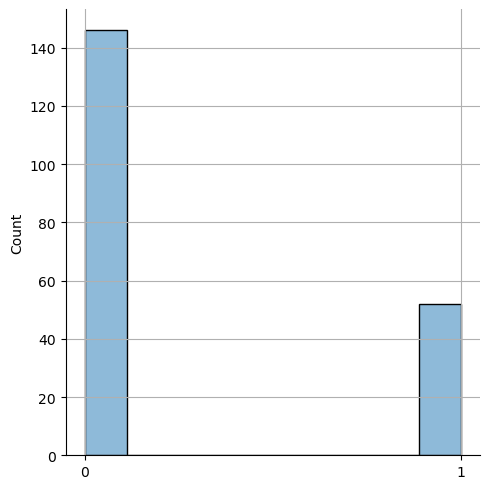

In [68]:
sns.displot(Y,legend=False, kind='hist')
plt.xticks([0,1])
plt.grid()